In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results    


  0%|          | 0/10099 [00:00<?, ?it/s]

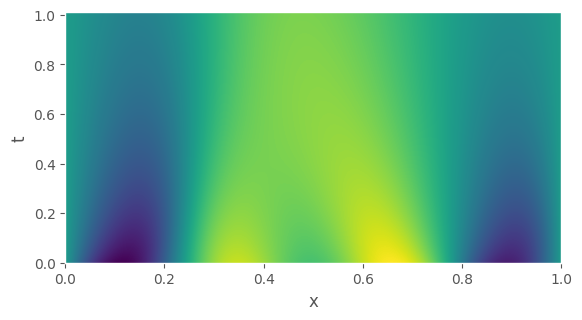

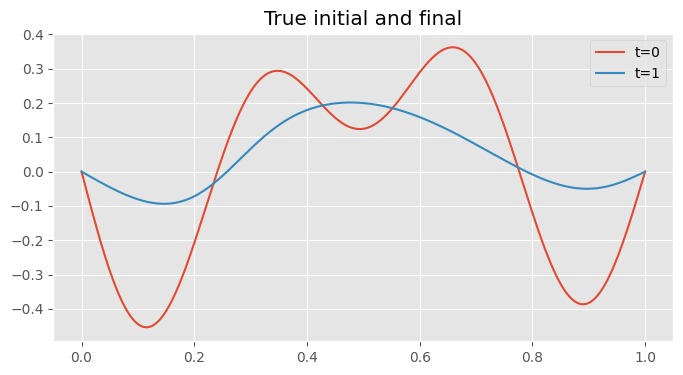

In [2]:
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0

kappa = 0.01
alpha = 0.5

u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

plt.imshow(sols[::-1],aspect = 0.5,extent = [0,1,t_vals[0],t_vals[-1]])
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.show()
plt.figure(figsize=(8,4))
num_fine_grid = 500
plt.title("True initial and final")
grid_points = jnp.linspace(0,1,num_fine_grid)
plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid),grid_points]).T),label = 't=0')
plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine_grid),grid_points]).T),label = 't=1')
plt.legend()
plt.show()

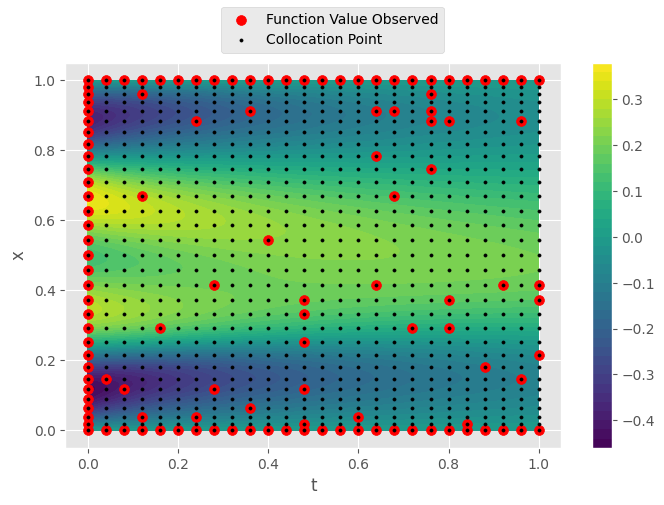

In [3]:
num_grid_x = 31
num_grid_t = 26
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

tx_all,tx_obs = setup_problem_data(
    tx_int,
    tx_bdy,
    40,
    jax.random.PRNGKey(55),
    times_to_observe = (0,)
)

u_true = u_true_function(tx_all)
u_obs = u_true_function(tx_obs)

num_fine_grid = 300
initial_time = 0
final_time = 1
t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
plot_input_data(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
)

In [4]:
from Kernels import get_anisotropic_gaussianRBF

def log1pexp(x):
    return jnp.log(jnp.exp(-x)+1) + x

def inv_log1pexp(y):
    return jnp.log(jnp.exp(y)-1)

def marginal_like(lengthscales):
    A = jnp.diag(lengthscales)
    kfunc = vectorize_kfunc(get_anisotropic_gaussianRBF(1.,A))
    K = kfunc(tx_obs,tx_obs)
    K = K + 1e-7 * diagpart(K)
    return (1/2) * u_obs.T@jnp.linalg.inv(K)@u_obs + (1/2) * jnp.linalg.slogdet(K).logabsdet

@jax.jit
@jax.value_and_grad
def loss(kernel_params):
    return marginal_like(log1pexp(kernel_params))

init_kp = jnp.array([10.,10.])
from jax import value_and_grad
from jaxopt import LBFGS,BFGS,NonlinearCG,GradientDescent
from LM_Solve import run_jaxopt

solver = GradientDescent(loss,value_and_grad=True,jit = False,tol = 1e-5)
#sol,conv_data,state = run_jaxopt(solver,init_kp)#solver.run(init_kp)
result = solver.run(init_kp)
sol = result.params
ML_lengthscales = log1pexp(sol)
print(1/(jnp.sqrt(ML_lengthscales)))

[0.4012455  0.14166379]


In [5]:
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel

u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,dx_k,dxx_k)

k_u = get_anisotropic_gaussianRBF(0.75,jnp.diag(ML_lengthscales))

u_model = CholInducedRKHS(
    tx_all,
    feature_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')

@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])

P_model = OperatorModel(k_P)    
    

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

In [6]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4
)


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.005431, Jres = 34.94, alpha = 0.08333, improvement_ratio = 0.996
Iteration 1, loss = 0.002868, Jres = 4.657, alpha = 0.06944, improvement_ratio = 1.008
Iteration 2, loss = 0.001971, Jres = 1.314, alpha = 0.05787, improvement_ratio = 1.009
Iteration 3, loss = 0.001534, Jres = 0.3913, alpha = 0.04823, improvement_ratio = 1.005
Iteration 4, loss = 0.001251, Jres = 0.1661, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 0.001038, Jres = 0.07574, alpha = 0.03349, improvement_ratio = 1.001
Iteration 50, loss = 2.373e-05, Jres = 0.005854, alpha = 9.157e-06, improvement_ratio = 0.9979
Iteration 100, loss = 5.218e-06, Jres = 9.677e-06, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 150, loss = 4.102e-06, Jres = 2.335e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 3.522e-06, Jres = 1.287e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 250, loss = 3.146e-06, Jres = 8.911e-07, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_1857286/2916455230.py:3: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([loss_vals,refinement_losses]))


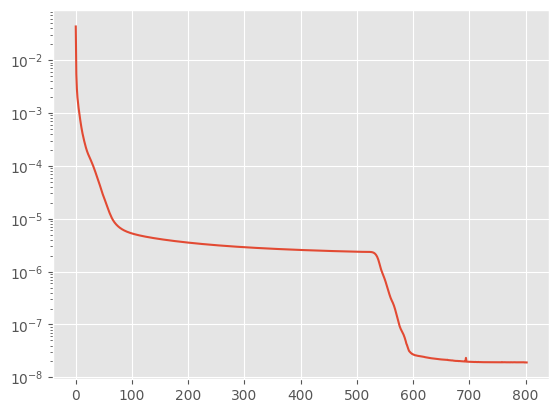

In [7]:
from LM_Solve import adaptive_refine_solution
p_adjusted,refinement_losses,reg_vals = adaptive_refine_solution(params,EqnModel,1e-3,300)
plt.plot(jnp.hstack([loss_vals,refinement_losses]))
plt.yscale('log')
plt.show()

Pre Refinement PDE MSE 3.7471067467996315e-06
Post Refinement PDE MSE 3.4268753239923695e-08


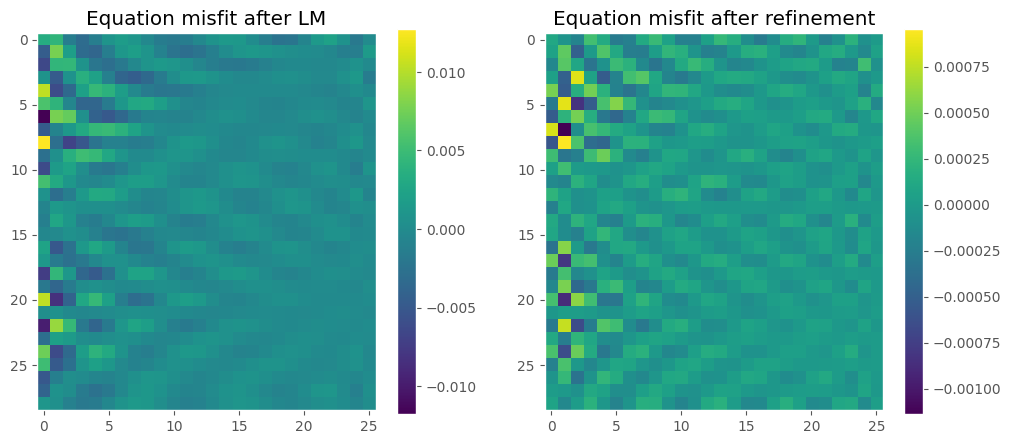

In [8]:
equation_residuals = EqnModel.equation_residual(params)
equation_residuals_refined = EqnModel.equation_residual(p_adjusted)

print("Pre Refinement PDE MSE",jnp.mean(equation_residuals**2))
print("Post Refinement PDE MSE",jnp.mean(equation_residuals_refined**2))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Equation misfit after LM")
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Equation misfit after refinement")
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()


In [9]:
from evaluation_metrics import get_nrmse,get_nmae,compute_results


,NRMSE,NMAE
1 Step,0.000191,0.000132
2 Step,0.122450,0.095688


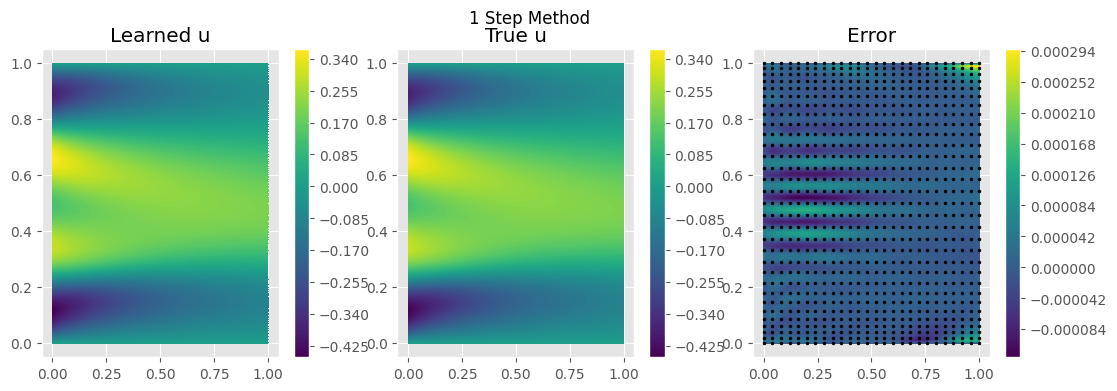

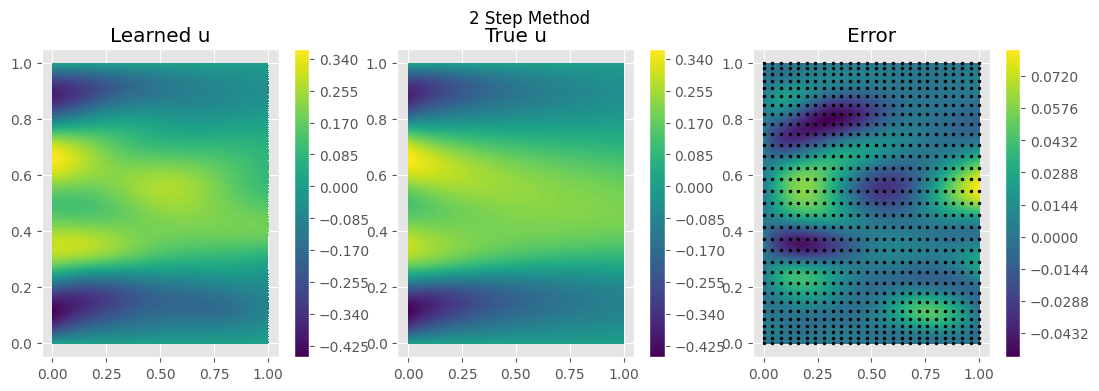

In [10]:
u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]


num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)
u_true_fine = u_true_function(tx_grid_fine)

display(compute_results(
    u_true_fine,
    {
        "1 Step":u_eval_fine,
        "2 Step":u_model.point_evaluate(tx_grid_fine,u_params_init),
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
))

plot_compare_error(
    tx_grid_fine,tx_all,None,lambda x:u_model.point_evaluate(x,u_sol),u_true_function,title= "1 Step Method"
)

plot_compare_error(
    tx_grid_fine,tx_all,None,lambda x:u_model.point_evaluate(x,u_params_init),u_true_function,title = "2 Step Method"
)

In [11]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
# hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = interpolant.partial_derivative(1,0)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
ux_true = interpolant.partial_derivative(0,1)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
uxx_true = interpolant.partial_derivative(0,2)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)


true_features = jnp.vstack([u_true_interior,ux_true,uxx_true]).T
true_features = jnp.hstack([tx_fine_int,true_features])

model_grid_features = EqnModel.get_stacked_eqn_features((u_sol,))
model_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_fine_int)
#model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_stacked_eqn_features((u_params_init,))

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = jnp.linalg.solve(K+1e-8*diagpart(K),EqnModel.get_stacked_rhs_op((u_params_init,)))

init_P_features_fine = EqnModel.get_single_eqn_features(u_model,u_params_init,tx_fine_int)
P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

compute_results(
    ut_true,
    {
        "1 Step Model Features":preds_ut_model_features,
        "1 Step True Features":preds_ut_true_features,
        "2 Step Model Features": P_preds_init_model_features_init,
        "2 Step True Features":P_preds_init_true_features,
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
)

,NRMSE,NMAE
1 Step Model Features,0.006455,0.005134
1 Step True Features,0.000254,0.000235
2 Step Model Features,0.375777,0.395212
2 Step True Features,0.316493,0.326465


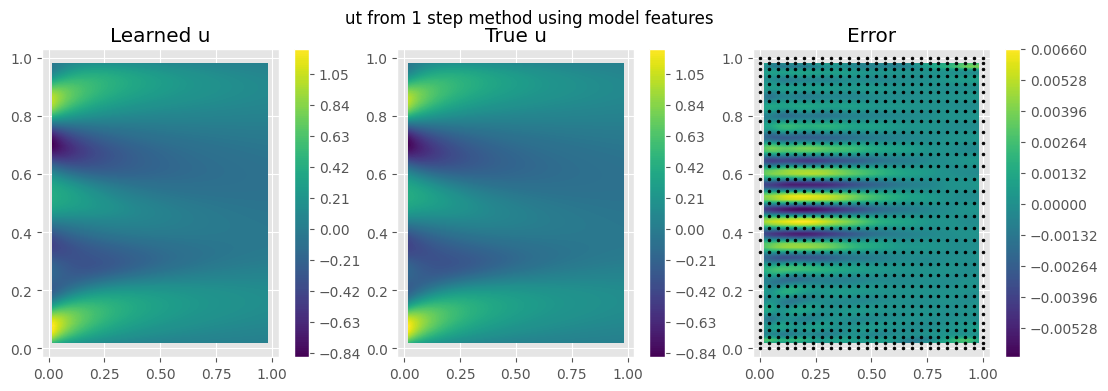

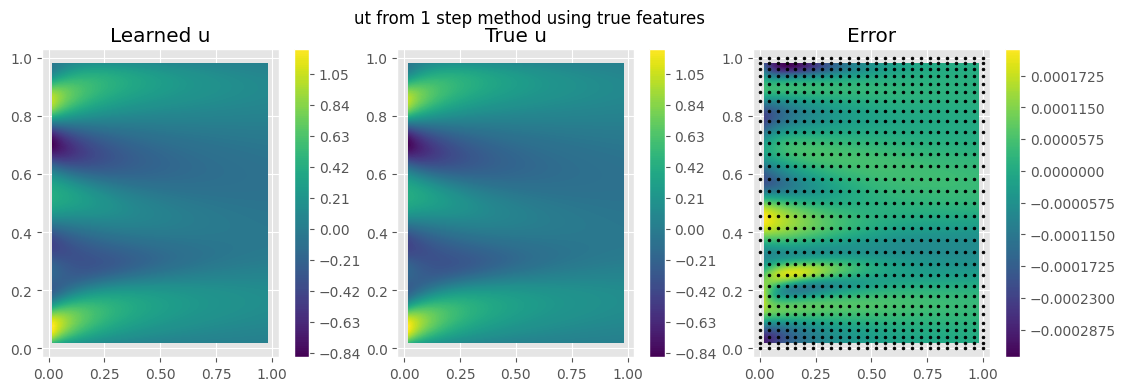

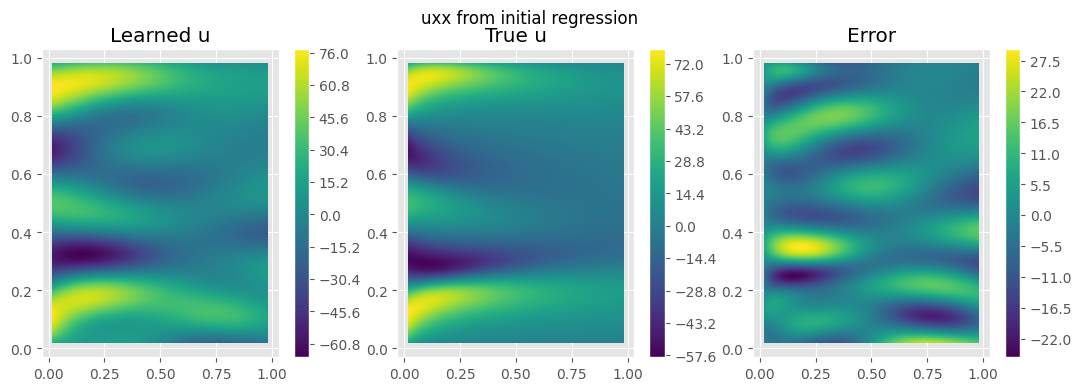

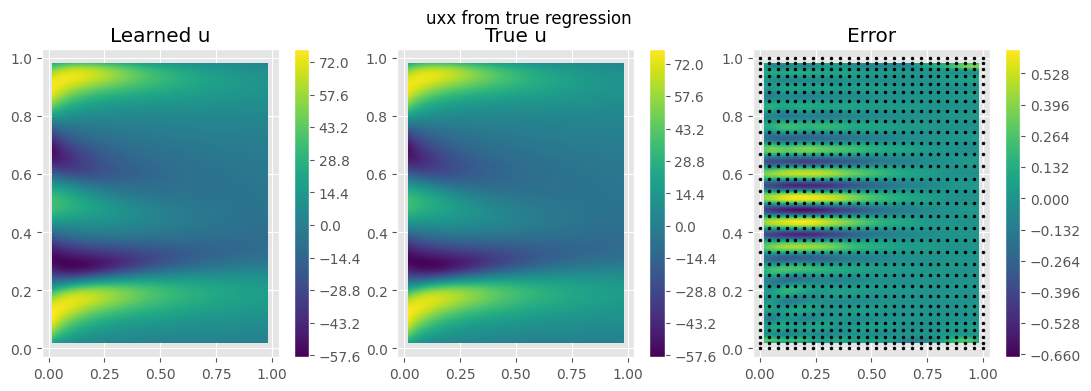

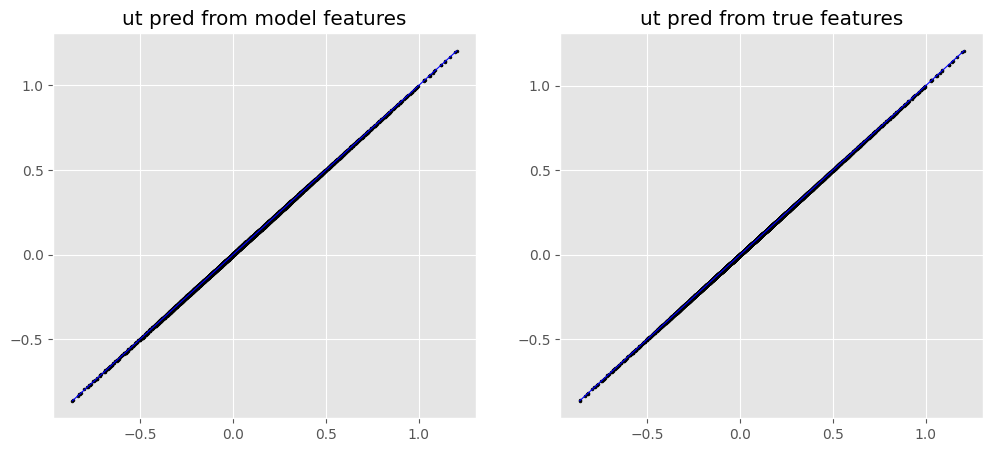

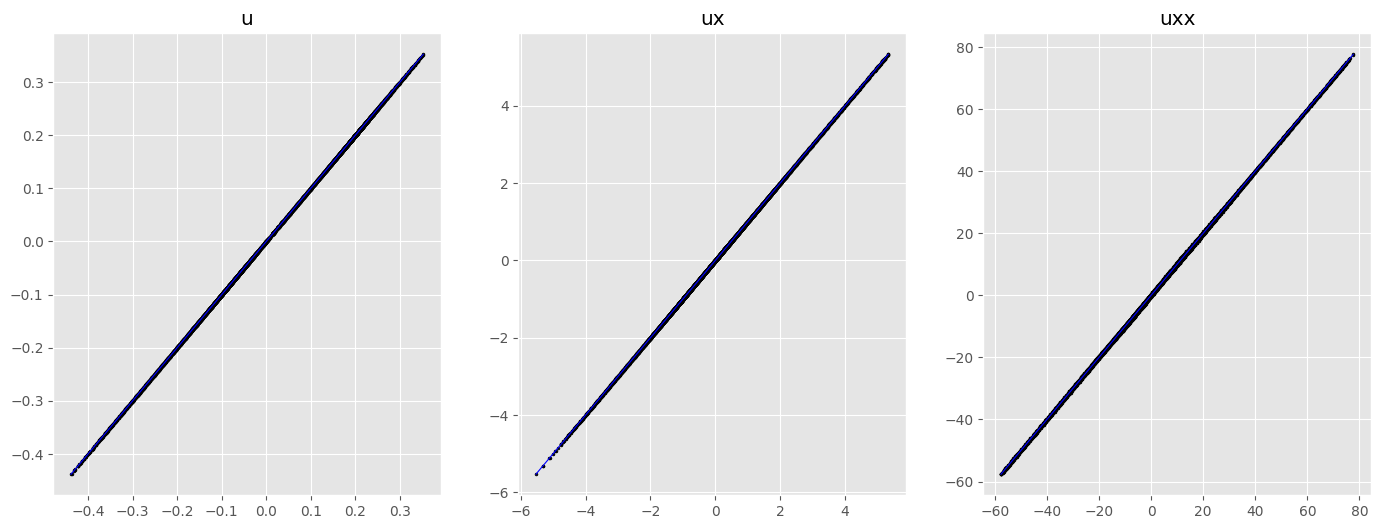

In [25]:
from plotting import compare_values,plot_compare_error_values

plot_compare_error_values(
    tx_fine_int,tx_all,None,preds_ut_model_features,ut_true,title = "ut from 1 step method using model features"
)

plot_compare_error_values(
    tx_fine_int,tx_all,None,preds_ut_true_features,ut_true,title = "ut from 1 step method using true features"
)

plot_compare_error_values(
    tx_fine_int,None,None,init_P_features_fine[:,4],uxx_true,title = "uxx from initial regression"
)

plot_compare_error_values(
    tx_fine_int,tx_all,None,model_features[:,4],uxx_true,title = "uxx from true regression"
)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('ut pred from model features')
compare_values(preds_ut_model_features,ut_true)
plt.subplot(1,2,2)
plt.title('ut pred from true features')
compare_values(preds_ut_true_features,ut_true)
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(1,3,1)
plt.title('u')
compare_values(model_features[:,2],true_features[:,2])
plt.subplot(1,3,2)
plt.title('ux')
compare_values(model_features[:,3],true_features[:,3])
plt.subplot(1,3,3)
plt.title("uxx")
compare_values(model_features[:,4],true_features[:,4])
plt.show()


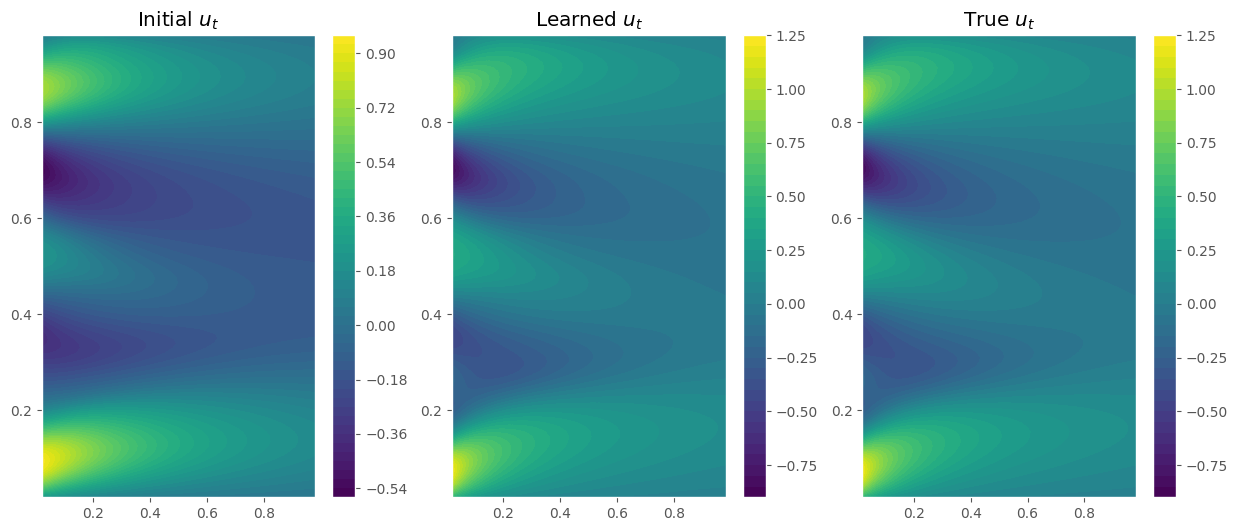

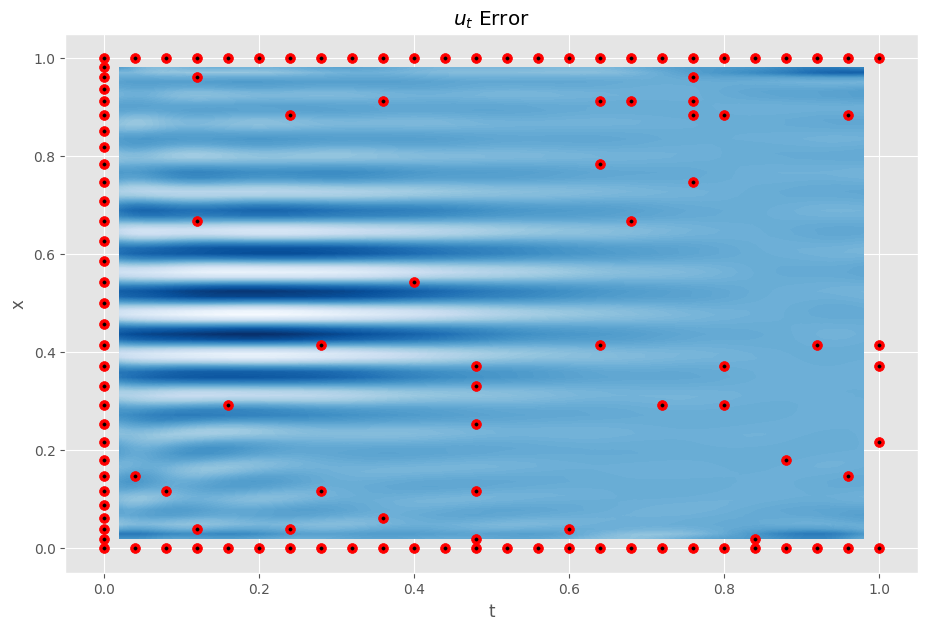

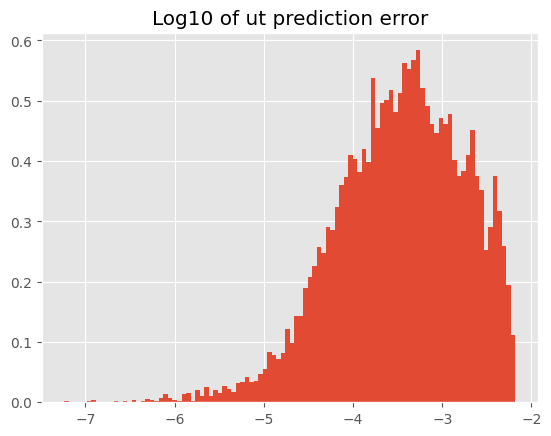

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)

plt.title("Initial $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],P_preds_init_model_features,50)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Learned $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],preds_ut_model_features,50,)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true,50)
plt.colorbar()

plt.show()
plt.figure(figsize=(11,7))
plt.title("$u_t$ Error")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,100,cmap = 'Blues')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50,label = 'Given value of u(t,x)')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 5,label = 'Given value of u(t,x)')

#plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.xlabel("t")
plt.ylabel("x")
plt.show()
plt.title("Log10 of ut prediction error")
plt.hist(jnp.log10(jnp.abs(ut_true-preds_ut_model_features) + 1e-20),100,density = True)
plt.show()

  0%|          | 0/10099 [00:00<?, ?it/s]

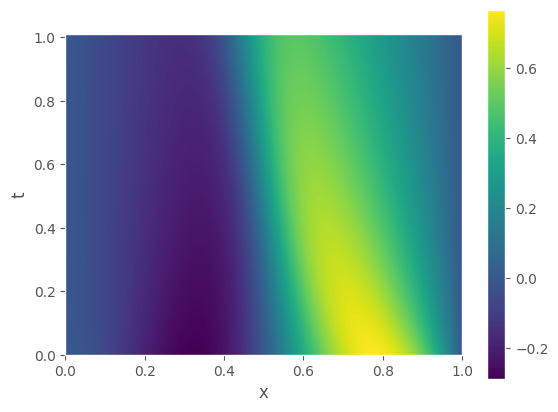

In [ ]:
def new_func_u0(x):
    u0 = -1 * x * np.sin(2 * jnp.pi * x)
    return u0

new_u_true_function,new_ut_true_function,new_interp,t_vals,sols_new = (
    build_burgers_data(func_u0=new_func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

plt.imshow(sols_new[::-1],aspect = 0.8,extent = [0,1,t_vals[0],t_vals[-1]])
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.colorbar()

In [ ]:
@jit
def get_pred_ut(input_features):
    return P_model.kernel_function(input_features,model_grid_features)@P_sol
tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])

new_obs = new_u_true_function(tx_init_bdy)


class PdeModel():
    datafit_weight = 50.
    @jit
    def get_grid_features(u_params):
        evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
        grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
        return jnp.hstack([tx_int,grid_features])
    
    @jit
    def get_grid_target(u_params):
        return u_model.evaluate_operators((dt_k,),tx_int,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(tx_init_bdy,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = PdeModel.eval_obs_points(u_params)
        return new_obs - obs_preds
    
    @jit
    def equation_residual(u_params):
        P_features = PdeModel.get_grid_features(u_params)
        P_model_preds = get_pred_ut(P_features)
        ugrid_target = PdeModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(u_params):
        eqn_res = PdeModel.equation_residual(u_params)
        data_res = PdeModel.datafit_residual(u_params)
        return jnp.hstack([
            PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(u_params):
        return jnp.linalg.norm(PdeModel.F(u_params))**2
    
    @jit
    def damping_matrix(u_params):
        return u_model.kmat+1e-5 * diagpart(u_model.kmat)

In [ ]:
new_u_init = 0*u_sol

u_params_pde,loss_vals_pde,JtRes_pde,improvement_ratios_pde,alpha_vals_pde,iterate_history_pde = LevenbergMarquadtMinimize(
    new_u_init.copy(),
    PdeModel,
    beta = 0.,
    max_iter = 101,
    init_alpha=0.05,
    line_search_increase_ratio=1.4,
    print_every = 10
)
u_pde_adj,refinement_losses_pde,reg_vals_pde = adaptive_refine_solution(u_params_pde,PdeModel,1e-1,150)


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.05587, Jres = 164.2, alpha = 0.04167, improvement_ratio = 0.9992
Iteration 1, loss = 0.003411, Jres = 0.3306, alpha = 0.03472, improvement_ratio = 0.939
Iteration 2, loss = 1.341e-05, Jres = 0.05275, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 8.284e-06, Jres = 0.0005792, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 7.411e-06, Jres = 2.625e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 6.884e-06, Jres = 1.662e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 5.598e-06, Jres = 8.971e-07, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 3.98e-06, Jres = 2.646e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 3.152e-06, Jres = 1.334e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 2.548e-06, Jres = 6.834e-08, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 1.913e-06, Jres = 1.748e-07, alpha = 4.579e-06, improvement_ratio = 1.0
Itera

  0%|          | 0/150 [00:00<?, ?it/s]

Sup norm error:  0.00047146933442454575
NRMSE  0.00046563489147352286


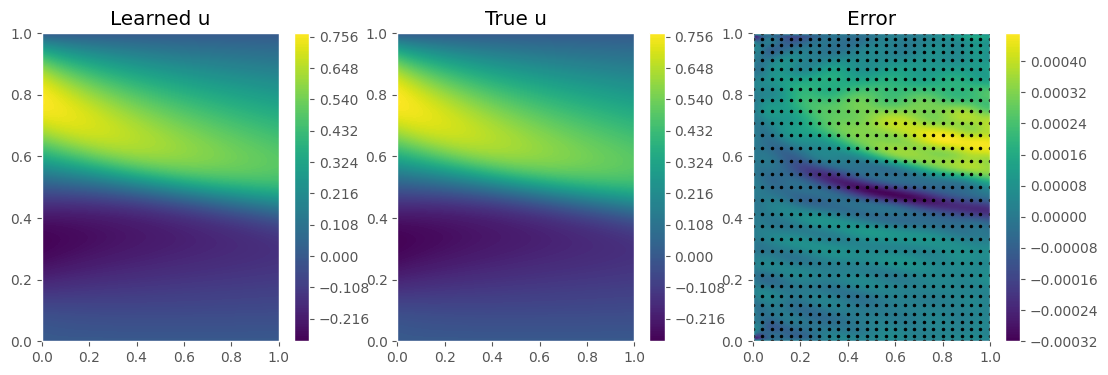

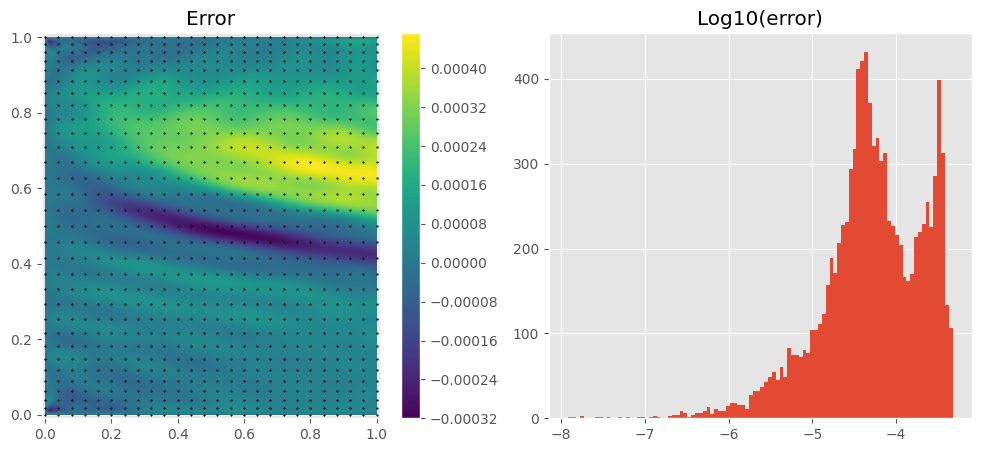

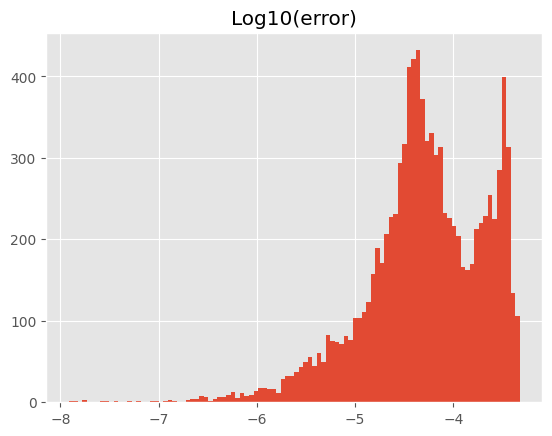

In [ ]:
from plotting import plot_compare_error
new_u_eval_fine = u_model.point_evaluate(tx_grid_fine,u_pde_adj)
new_u_true_fine = new_u_true_function(tx_grid_fine)

print("Sup norm error: ",jnp.max(jnp.abs(new_u_true_fine-new_u_eval_fine)))
print("NRMSE ",get_nrmse(new_u_true_fine,new_u_eval_fine))

plot_compare_error(
    tx_grid_fine,
    tx_all,
    None,
    lambda x:u_model.point_evaluate(x,u_pde_adj),
    new_u_true_function
)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine-new_u_eval_fine,200)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],s = 1,c='black')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.title("Error")
plt.subplot(1,2,2)
plt.title("Log10(error)")
plt.hist(jnp.log10(jnp.abs(new_u_true_fine-new_u_eval_fine)),100)
plt.show()

plt.title("Log10(error)")
plt.hist(jnp.log10(jnp.abs(new_u_true_fine-new_u_eval_fine)),100)
plt.show()

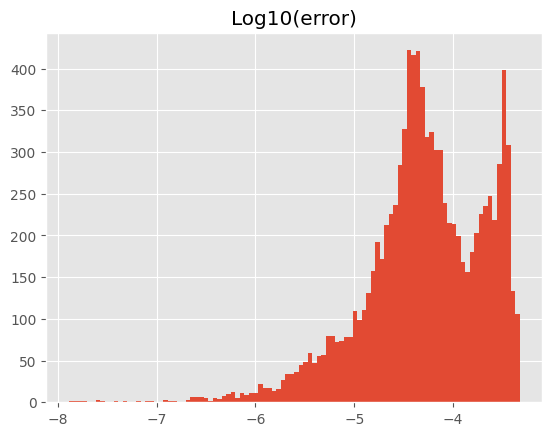